### Data Visualization Notebook

In [81]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pubchempy
import pandas as pd
from itertools import compress
import seaborn as sns
from matchms.importing import load_from_mgf

from rdkit import Chem
from rdkit.Chem import Draw


from matchms import calculate_scores
from matchms.plotting.spectrum_plots import plot_spectra_mirror, plot_spectrum


from matplotlib import animation, rc
from celluloid import Camera # getting the camera
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

In [82]:
path_data = "../data"

print("Load reference and query data.")
file_mgf_reference = os.path.join(path_data, "GNPS-LIBRARY.mgf")
reference_spectra = list(load_from_mgf(file_mgf_reference))

file_mgf_query = os.path.join(path_data, "pseudo_query_neg_v1.mgf")
query_spectra = list(load_from_mgf(file_mgf_query))

print(f"Detected {len(reference_spectra)} reference spectra and {len(query_spectra)} query spectra.")

Load reference and query data.
Detected 12855 reference spectra and 1614 query spectra.


#### Metadata

In [83]:
# Treat Libraries in pandas DataFrames
Q = pd.DataFrame({"spectrum": query_spectra, "library": "query"})
R = pd.DataFrame({"spectrum": reference_spectra, "library": "reference"})


def extract_metadata(df, keys):
    for key in keys:
        df[key] = df["spectrum"].apply(lambda x: x.get(key))
    

extract_metadata(Q, Q["spectrum"][0].metadata.keys())
extract_metadata(R, R["spectrum"][0].metadata.keys())
M = pd.concat([Q, R])



In [84]:
Q.head()

,spectrum,library,title,mslevel,scans,scanindex,centroided,polarity,precscannum,pepmass,...,basepeakmz,basepeakintensity,ionisationenergy,lowmz,highmz,injectiontime,feature_id,retention_time,collision_energy,precursor_mz
0,<matchms.Spectrum.Spectrum object at 0x2bd7725f0>,query,msLevel 2; retentionTime ; scanNum,2,1,1,TRUE,0,1,"(112.98553637, None)",...,68.99723544,656,0,68.99723544,68.99723544,0,FT1,247.3932,10,112.985536
1,<matchms.Spectrum.Spectrum object at 0x2b5914670>,query,msLevel 2; retentionTime ; scanNum,2,2,2,TRUE,0,2,"(112.98557467, None)",...,45.00066804,268,0,45.00066804,45.00066804,0,FT2,377.1270,20,112.985575
2,<matchms.Spectrum.Spectrum object at 0x2bd772650>,query,msLevel 2; retentionTime ; scanNum,2,3,3,TRUE,0,3,"(112.98557452, None)",...,44.99716261,314,0,44.99716261,44.99716261,0,FT3,258.8022,30,112.985575
3,<matchms.Spectrum.Spectrum object at 0x2bd7726b0>,query,msLevel 2; retentionTime ; scanNum,2,4,4,TRUE,0,4,"(112.98552874, None)",...,44.99853363,266,0,44.99853363,44.99853363,0,FT4,278.4588,40,112.985529
4,<matchms.Spectrum.Spectrum object at 0x2bd772830>,query,msLevel 2; retentionTime ; scanNum,2,5,5,TRUE,0,5,"(129.05574413, None)",...,129.05973069,220,0,129.05973069,519.2963068,0,FT5,172.1430,10,129.055744


In [85]:
# Define plot colors
color_palette = sns.light_palette("seagreen", 5)
default_color = color_palette[-1]

In [86]:
R.columns


Index(['spectrum', 'library', 'pepmass', 'charge', 'mslevel',
       'source_instrument', 'seq', 'ionmode', 'organism', 'smiles', 'inchi',
       'inchiaux', 'pubmed', 'libraryquality', 'scans', 'file_name',
       'compound_name', 'principal_investigator', 'data_collector',
       'submit_user', 'spectrum_id', 'precursor_mz'],
      dtype='object')

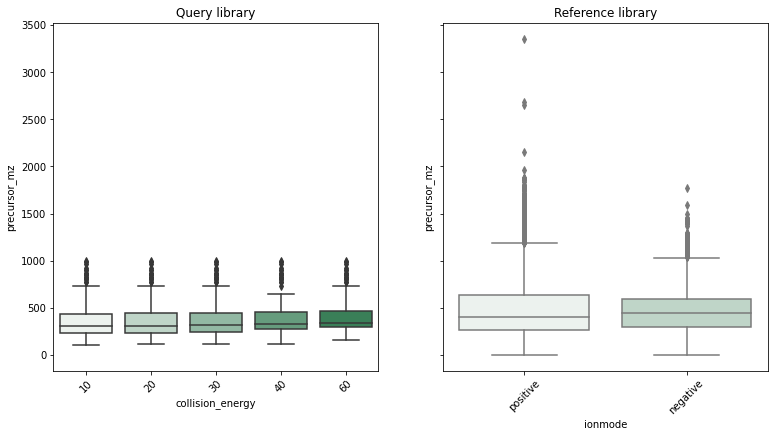

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4), gridspec_kw={'width_ratios': [1, 1]}, sharey=True)
for ax in axs:
    ax.tick_params('x', labelrotation=45)

sns.boxplot(ax=axs[0], data=Q, y='precursor_mz', palette=color_palette, x="collision_energy")
sns.boxplot(ax=axs[1], data=R, y='precursor_mz', palette=color_palette, x="ionmode")

axs[0].set_title("Query library")
axs[1].set_title("Reference library")
plt.show()

Retention Times

Examine peak counts

In [88]:
Q["peak_count"] = Q["spectrum"].apply(lambda x: len(x.peaks))
Q["totioncurrent"] = Q["spectrum"].apply(lambda x: sum(x.peaks.intensities))
Q["log_totioncurrent"] = Q["totioncurrent"].apply(np.log) 

R["peak_count"] = R["spectrum"].apply(lambda x: len(x.peaks))
R["totioncurrent"] = R["spectrum"].apply(lambda x: sum(x.peaks.intensities))
R["log_totioncurrent"] = R["totioncurrent"].apply(np.log) 





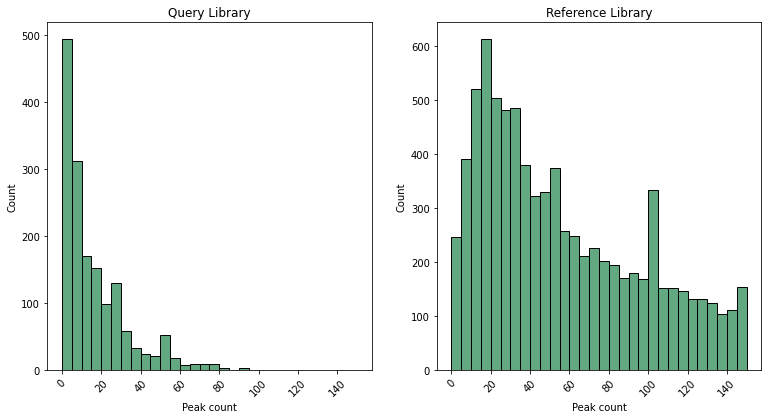

In [89]:

fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4), gridspec_kw={'width_ratios': [1, 1]}, sharey=False)
for ax in axs:
    ax.tick_params('x', labelrotation=45)
    ax.set_xlabel("Peak count")

sns.histplot(ax=axs[0], data=Q, x='peak_count', color=default_color, binwidth=5, binrange=[0, 150])
sns.histplot(ax=axs[1], data=R, x='peak_count', color=default_color, binwidth=5, binrange=[0, 150])

axs[0].set_title("Query Library")
axs[1].set_title("Reference Library")
plt.show()

<AxesSubplot: xlabel='log_totioncurrent', ylabel='Count'>

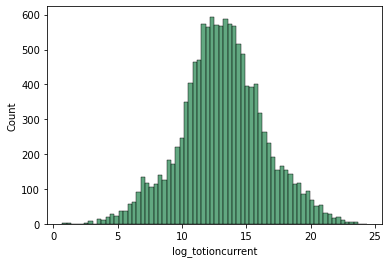

In [90]:
#Q["totioncurrent"] = Q["totioncurrent"].astype(int)
Q["log_totioncurrent"] = Q["totioncurrent"].apply(np.log)
sns.histplot(R, x="log_totioncurrent", color=default_color)
#Q["totioncurrent"]

In [96]:
R["name"] = R["compound_name"].apply(lambda x: " ".join(x.split(" ")[:-1]))
R["ionisation"] = R["compound_name"].apply(lambda x: x.split(" ")[-1])

In [97]:

R["ionisation"].value_counts()

M+H            8259
M-H            1471
M+Na           1325
M+NH4           204
M-H2O+H         203
               ... 
iso-C11           1
M-HAc             1
n-C12             1
anteiso-C11       1
MS34+Na           1
Name: ionisation, Length: 82, dtype: int64

In [100]:

sum(R[R.ionisation == 'M+H']["smiles"].value_counts()[2:] > 3 )

                                                                                                         1668
N/A                                                                                                       432
C1=CC=[N+](C(=C1)CCCCCCCC=O)CCCCCC=O                                                                       20
OC(=O)CC1=CNC2=C1C=CC=C2                                                                                   18
NCCCCN                                                                                                     14
                                                                                                         ... 
CC(=O)NC1=C2C(=CSS2)NC1=O                                                                                   1
CC(=O)NC1=C2C(=CSS2)N(C1=O)C                                                                                1
CC(C)CCCCCCCCC=CC(=O)NC1C(C(C(OC1OC2C(C(C(C(O2)CO)O)O)NC(=O)C)CC(C3C(C(C(O3)N4C=CC(=O)NC4=O)O)O)O)O)O       1
CCCCCCCCC/

In [93]:
R.columns

Index(['spectrum', 'library', 'pepmass', 'charge', 'mslevel',
       'source_instrument', 'seq', 'ionmode', 'organism', 'smiles', 'inchi',
       'inchiaux', 'pubmed', 'libraryquality', 'scans', 'file_name',
       'compound_name', 'principal_investigator', 'data_collector',
       'submit_user', 'spectrum_id', 'precursor_mz', 'peak_count',
       'totioncurrent', 'log_totioncurrent', 'name'],
      dtype='object')